#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

NAIVE BAYES : 
---

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split


SMALL_VALUE = 1e-4

class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    # dla każdej unikalnej wartości oblicza prawdopodobieństwo wystąpienia danej klasy
    def calculate_priors(self, train_classes: np.ndarray) -> dict:

        priors = {}
        unique_values = np.unique(train_classes)

        for value in unique_values:
            probability = train_classes.tolist().count(value) / len(train_classes)
            priors[value] = probability
        return priors


    def calculate_likelihood(self, train_attributes: np.ndarray, train_classes: np.ndarray) -> dict:

        likelihoods = {}
        unique_classes = np.unique(train_classes)

        # Ilość atrybutów
        num_attributes = train_attributes.shape[1]

        for item_class in unique_classes:
            likelihoods[item_class] = {}

            # Dla każdego atrybutu
            for attribute in range(num_attributes):
                # Wybierz wartości atrybutu dla danej klasy
                class_attribute_values = train_attributes[train_classes == item_class, attribute]
                total_values = len(class_attribute_values)

                # Zlicz wystąpienia unikalnych wartości
                unique_values, counts = np.unique(class_attribute_values, return_counts=True)

                probabilities = counts / total_values

                # Zapisz do słownika
                likelihoods[item_class][attribute] = dict(zip(unique_values, probabilities))

        return likelihoods
        # likehoods wygląda tak {klasa: atrubyt[0, 1, 2, 3] (któa kolumna): {wartość_atrubutu (do którego przedziału należy) : prawdopodobieństwo}}


    # budujemy klasyfikator
    def build_classifier(self, train_attributes: np.ndarray, train_classes: np.ndarray):
        self.priors = self.calculate_priors(train_classes)
        self.likelihoods = self.calculate_likelihood(train_attributes, train_classes)


    # dzielimy wartości na 4 przedziały
    @staticmethod
    def data_discretization(data, amount=4):
        cols = data.shape[1]

        # tworzymy tabelę, którą iniclijemy zerami
        discretized_data = np.zeros_like(data, dtype=int)

        # dla każdej kolumny
        for col in range(cols):
            # robimy 4 równe przedziały [:, col] -> zwraca nam daną kolumnę
            bins = np.linspace(start=np.min(data[:, col]), stop=np.max(data[:, col]), num=amount)

            # obliczamy indeksy przedziałów dla danej kolumny
            discretized_data[:, col] = np.digitize(data[:, col], bins)

        return discretized_data



    # obliczamy prawdopodobieństwo wystąpienia danej klasy (stosujemy logarytmy bo lepiej trzyma wartość)
    def predict(self, sample):
        class_propabilities = {}

        for item_class in np.unique(y_train):
            class_propabilities[item_class] = np.log(self.priors[item_class])

            for atribute, value in enumerate(sample):
                # dla każdego atrybutu bierzemy jego prawdopodobieństwo warunkowe, a jak wyniosło ono 0 to bierzemy małą wartość
                likelihood = self.likelihoods[item_class][atribute].get(value, SMALL_VALUE)
                class_propabilities[item_class] += np.log(likelihood)

        return max(class_propabilities, key=class_propabilities.get)


In [36]:
# Funkcja do treningu i testowania klasyfikatora
def test_classfier(classifier, train_features, train_classes, test_features, test_classes):
    classifier.build_classifier(train_features, train_classes)
    predictions = [classifier.predict(sample) for sample in test_features]
    accuracy = np.mean(predictions == test_classes)
    return accuracy

In [37]:
nb = NaiveBayes()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
discretized_x_train = NaiveBayes.data_discretization(x_train)
discretized_x_test = NaiveBayes.data_discretization(x_test)

nb_accuracy_sum = test_classfier(nb, discretized_x_train, y_train, discretized_x_test, y_test)
print(f"Accuracy : {nb_accuracy_sum}")

Accuracy : 0.9333333333333333


NAIVE GAUSSIAN BAYES : 
---

In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math

SMALL_VALUE = 1e-4
class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def calculate_priors(self, train_classes: np.ndarray) -> dict:
        priors = {}
        unique_values = np.unique(train_classes)

        for value in unique_values:
            probability = train_classes.tolist().count(value) / len(train_classes)
            priors[value] = probability
        return priors

    def calculate_likelihood(self, train_attributes: np.ndarray, train_classes: np.ndarray) -> dict:
        likelihoods = {}
        unique_classes = np.unique(train_classes)

        num_attributes = train_attributes.shape[1]

        for unique_class in unique_classes:
            likelihoods[unique_class] = {}

            for attribute in range(num_attributes):
                mean = np.mean(train_attributes[train_classes == unique_class, attribute])
                std = np.std(train_attributes[train_classes == unique_class, attribute])

                likelihoods[unique_class][attribute] = (mean, std)

        return likelihoods

    def build_classifier(self, train_features, train_classes):
        self.priors = self.calculate_priors(train_classes)
        self.likelihoods = self.calculate_likelihood(train_features, train_classes)

    @staticmethod
    def normal_dist(x, mean, std):
        if std > 0:
            e = math.exp(-(x - mean) ** 2 / (2 * (std ** 2)))
            normal_distribution = (1 / (std * math.sqrt(2 * math.pi))) * e
        else:
            normal_distribution = 0

        return normal_distribution

    def predict(self, sample):
        class_predictions = {}
        unique_classes = np.unique(y_train)

        for unique_class in unique_classes:
            class_predictions[unique_class] = np.log(self.priors[unique_class])

            for attribute, value in enumerate(sample):
                mean = self.likelihoods[unique_class][attribute][0]
                std = self.likelihoods[unique_class][attribute][1]

                fx = self.normal_dist(value, mean, max(std, SMALL_VALUE))
                class_predictions[unique_class] += np.log(max(fx, SMALL_VALUE))

        predict_class = max(class_predictions, key=class_predictions.get)

        return predict_class

In [38]:
nb = GaussianNaiveBayes()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

nb_accuracy_sum = test_classfier(nb, x_train, y_train, x_test, y_test)
print(f"Accuracy : {nb_accuracy_sum}")

Accuracy : 1.0


Porównanie NaiveBayes z GaussianNaiveBayes :
---

In [39]:
# Załaduj dane Iris
iris = load_iris()
X = iris.data
y = iris.target

# Zdefiniuj zakres seedów
seed_range = range(1, 11)

# Utwórz tabelę wyników
results = []

for i in seed_range:


    # Podział danych na zbiór treningowy i testowy
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

    # Dla klasyfikatora Naive Bayes
    nb = NaiveBayes()
    discretized_x_train = nb.data_discretization(x_train)
    discretized_x_test = nb.data_discretization(x_test)
    nb_accuracy = test_classfier(nb, discretized_x_train, y_train, discretized_x_test, y_test)

    # Dla klasyfikatora Gaussian Naive Bayes
    gnb = GaussianNaiveBayes()
    gnb_accuracy = test_classfier(gnb, x_train, y_train, x_test, y_test)


    # Dodaj wyniki do tabeli
    results.append({
        'NaiveBayes Accuracy': nb_accuracy,
        'GaussianNaiveBayes Accuracy': gnb_accuracy
    })
# Utwórz ramkę danych Pandas z wynikami
df_results = pd.DataFrame(results)

# Oblicz średnie wartości
nb_mean = df_results['NaiveBayes Accuracy'].mean()
gnb_mean = df_results['GaussianNaiveBayes Accuracy'].mean()

# Wydrukuj tabelę w terminalu
print(df_results)
print("---------------------------")
print(f'NB mean accuracy over all seeds : {nb_mean}')
print(f'GNB mean accuracy over all seeds : {gnb_mean}')

   NaiveBayes Accuracy  GaussianNaiveBayes Accuracy
0             1.000000                     1.000000
1             0.866667                     0.933333
2             0.933333                     0.866667
3             0.933333                     1.000000
4             1.000000                     1.000000
5             0.933333                     1.000000
6             0.733333                     1.000000
7             0.933333                     1.000000
8             0.600000                     0.933333
9             0.666667                     0.866667
---------------------------
NB mean accuracy over all seeds : 0.86
GNB mean accuracy over all seeds : 0.96


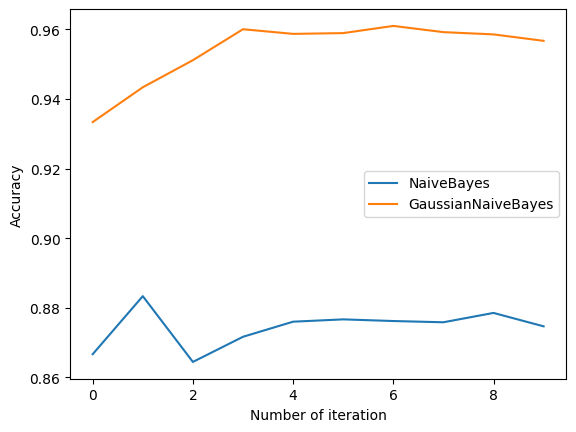

In [42]:
# na wykresie
import matplotlib.pyplot as plt


loop_result_nb = []
loop_results_gnb = []
results_nb = []
results_gnb = []

for j in range(1, 11):
# Utwórz listę wartości dla osi x
    for i in range(1, 11):
        # Podział danych na zbiór treningowy i testowy
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

        # Dla klasyfikatora Naive Bayes
        nb = NaiveBayes()
        discretized_x_train = nb.data_discretization(x_train)
        discretized_x_test = nb.data_discretization(x_test)
        nb_accuracy = test_classfier(nb, discretized_x_train, y_train, discretized_x_test, y_test)

        # Dla klasyfikatora Gaussian Naive Bayes
        gnb = GaussianNaiveBayes()
        gnb_accuracy = test_classfier(gnb, x_train, y_train, x_test, y_test)

        # Dodaj wyniki do tabeli
        results_nb.append(nb_accuracy)
        results_gnb.append(gnb_accuracy)

    loop_result_nb.append(np.mean(results_nb))
    loop_results_gnb.append(np.mean(results_gnb))

# narysuj wykres
plt.plot(loop_result_nb, label='NaiveBayes')
plt.plot(loop_results_gnb, label='GaussianNaiveBayes')
plt.xlabel('Number of iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Accuracy NaiveBayes w zależności od ilości przedziałów na które dzielimy : 
---

In [44]:
# Załaduj dane Iris
iris = load_iris()
X = iris.data
y = iris.target

# Zdefiniuj zakres seedów
seed_range = range(1, 11)

# Utwórz tabelę wyników
results = []

for value in [2, 3, 4, 5, 6, 7, 8, 100, 500, 1000]:
    for i in seed_range:
        # Podział danych na zbiór treningowy i testowy
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

        # Dla klasyfikatora Naive Bayes
        nb = NaiveBayes()
        discretized_x_train = nb.data_discretization(x_train, value)
        discretized_x_test = nb.data_discretization(x_test, value)
        nb_accuracy = test_classfier(nb, discretized_x_train, y_train, discretized_x_test, y_test)


    # Dodaj wyniki do tabeli
    results.append({
        'NaiveBayes Accuracy': nb_accuracy,
        'Amount of bins' : value
    })

# Utwórz ramkę danych Pandas z wynikami
df_results = pd.DataFrame(results)

print(df_results)

   NaiveBayes Accuracy  Amount of bins
0             0.600000               2
1             0.733333               3
2             0.866667               4
3             0.733333               5
4             0.866667               6
5             0.933333               7
6             0.933333               8
7             0.600000             100
8             0.600000             500
9             0.600000            1000


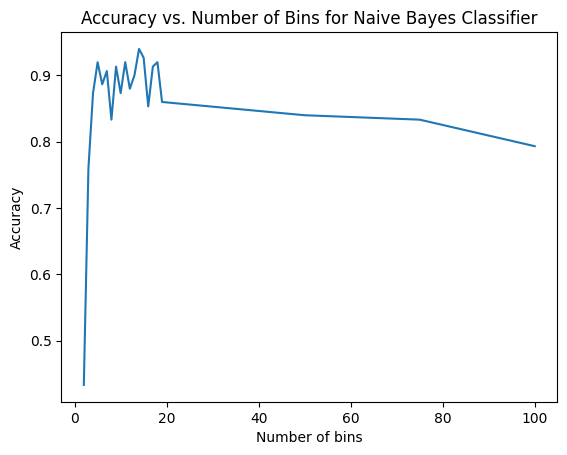

In [35]:
# Załaduj dane Iris
iris = load_iris()
X = iris.data
y = iris.target

accuracy = []
num_of_bins = []

values = np.arange(2, 20, 1)
values = np.append(values, [50, 75, 100])


for value in (values):
    res = []
    for i in range(1, 11):
        # Podział danych na zbiór treningowy i testowy z użyciem aktualnego seeda
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

        # Dla klasyfikatora Naive Bayes
        nb = NaiveBayes()
        discretized_x_train = nb.data_discretization(x_train, value)
        discretized_x_test = nb.data_discretization(x_test, value)
        nb_accuracy = test_classfier(nb, discretized_x_train, y_train, discretized_x_test, y_test)

        res.append(nb_accuracy)

    accuracy.append(np.mean(res))
    num_of_bins.append(value)

# Wykres
plt.plot(num_of_bins, accuracy)
plt.xlabel('Number of bins')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Bins for Naive Bayes Classifier')
plt.show()

Wnioski : 
---

- Zwiększenie liczby podziałów w dyskretyzacji dla NaiveBayes zwiększa accuracy. Dobre wyniki widoczne są już od 4 w górę, gdzie sięga ona okolice 80%+ i utrzymuje się przez jakiś czas. Dla mniejszych wartości wynosić może w okolicach nawet 40%. Dla zbyt dużych ilości kubełków, accuracy spada do niższych wartości
- GausianNaiveBayes jest bardziej skuteczny niż NaiveBayes i daje wyniki średnie w okolicahc 91%+
- Dla seedów testowych (tj. seed 123) NaiveBayes dał accuracy 93% a GaussianNaiveBayes dał 100%